In [1]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, Dense, LayerNormalization, Dropout, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the Transformer Encoder Layer
def encoder_layer(embed_dim, num_heads, ff_dim):
    inputs = Input(shape=(None, embed_dim))
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return tf.keras.Model(inputs=inputs, outputs=out2)

In [3]:
# Define the Transformer Decoder Layer
def decoder_layer(embed_dim, num_heads, ff_dim):
    inputs = Input(shape=(None, embed_dim))
    enc_output = Input(shape=(None, embed_dim))
    
    attn_output1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output1 = Dropout(0.1)(attn_output1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output1)
    
    attn_output2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(out1, enc_output)
    attn_output2 = Dropout(0.1)(attn_output2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn_output2)
    
    ffn_output = Dense(ff_dim, activation='relu')(out2)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out3 = LayerNormalization(epsilon=1e-6)(out2 + ffn_output)
    
    return tf.keras.Model(inputs=[inputs, enc_output], outputs=out3)

In [4]:
# Define the full Transformer Model
def create_transformer_model(vocab_size, embed_dim, num_heads, ff_dim, max_len):
    inputs = Input(shape=(max_len,))
    embeddings = Embedding(vocab_size, embed_dim)(inputs)
    
    encoder = encoder_layer(embed_dim, num_heads, ff_dim)
    enc_output = encoder(embeddings)
    
    decoder = decoder_layer(embed_dim, num_heads, ff_dim)
    dec_output = decoder([embeddings, enc_output])
    
    outputs = Dense(vocab_size, activation='softmax')(dec_output)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Function to plot accuracy and loss graphs
def plot_graphs(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [6]:
# Sample dataset
dataset = """About the Program
What is the course fee for  Data Science Mentorship Program (DSMP 2023)
The course follows a monthly subscription lstm_model where you have to make monthly payments of Rs 799/month.
What is the total duration of the course?
The total duration of the course is 7 months. So the total course fee becomes 799*7 = Rs 5600(approx.)
What is the syllabus of the mentorship program?
We will be covering the following modules:
Python Fundamentals
Python libraries for Data Science
Data Analysis
SQL for Data Science
Maths for Machine Learning
ML Algorithms
Practical ML
MLOPs
Case studies
You can check the detailed syllabus here - https://learnwith.campusx.in/courses/CampusX-Data-Science-Mentorship-Program-637339afe4b0615a1bbed390
Will Deep Learning and NLP be a part of this program?
No, NLP and Deep Learning both are not a part of this program’s curriculum.
What if I miss a live session? Will I get a recording of the session?
Yes all our sessions are recorded, so even if you miss a session you can go back and watch the recording.
Where can I find the class schedule?
Checkout this google sheet to see month by month time table of the course - https://docs.google.com/spreadsheets/d/16OoTax_A6ORAeCg4emgexhqqPv3noQPYKU7RJ6ArOzk/edit?usp=sharing.
What is the time duration of all the live sessions?
Roughly, all the sessions last 2 hours.
What is the language spoken by the instructor during the sessions?
Hinglish
How will I be informed about the upcoming class?
You will get a mail from our side before every paid session once you become a paid user.
Can I do this course if I am from a non-tech background?
Yes, absolutely.
I am late, can I join the program in the middle?
Absolutely, you can join the program anytime.
If I join/pay in the middle, will I be able to see all the past lectures?
Yes, once you make the payment you will be able to see all the past content in your dashboard.
Where do I have to submit the task?
You don’t have to submit the task. We will provide you with the solutions, you have to self evaluate the task yourself.
Will we do case studies in the program?
Yes.
Where can we contact you?
You can mail us at nitish.campusx@gmail.com
Payment/Registration related questions
Where do we have to make our payments? Your YouTube channel or website?
You have to make all your monthly payments on our website. Here is the link for our website - https://learnwith.campusx.in/
Can we pay the entire amount of Rs 5600 all at once?
Unfortunately no, the program follows a monthly subscription lstm_model.
What is the validity of monthly subscription? Suppose if I pay on 15th Jan, then do I have to pay again on 1st Feb or 15th Feb
15th Feb. The validity period is 30 days from the day you make the payment. So essentially you can join anytime you don’t have to wait for a month to end.
What if I don’t like the course after making the payment. What is the refund policy?
You get a 7 days refund period from the day you have made the payment.
I am living outside India and I am not able to make the payment on the website, what should I do?
You have to contact us by sending a mail at nitish.campusx@gmail.com
Post registration queries
Till when can I view the paid videos on the website?
This one is tricky, so read carefully. You can watch the videos till your subscription is valid. Suppose you have purchased subscription on 21st Jan, you will be able to watch all the past paid sessions in the period of 21st Jan to 20th Feb. But after 21st Feb you will have to purchase the subscription again.
But once the course is over and you have paid us Rs 5600(or 7 installments of Rs 799) you will be able to watch the paid sessions till Aug 2024.
Why lifetime validity is not provided?
Because of the low course fee.
Where can I reach out in case of a doubt after the session?
You will have to fill a google form provided in your dashboard and our team will contact you for a 1 on 1 doubt clearance session
If I join the program late, can I still ask past week doubts?
Yes, just select past week doubt in the doubt clearance google form.
I am living outside India and I am not able to make the payment on the website, what should I do?
You have to contact us by sending a mail at nitish.campusx@gmai.com
Certificate and Placement Assistance related queries
What is the criteria to get the certificate?
There are 2 criterias:
You have to pay the entire fee of Rs 5600
You have to attempt all the course assessments.
I am joining late. How can I pay payment of the earlier months?
You will get a link to pay fee of earlier months in your dashboard once you pay for the current month.
I have read that Placement assistance is a part of this program. What comes under Placement assistance?
This is to clarify that Placement assistance does not mean Placement guarantee. So we dont guarantee you any jobs or for that matter even interview calls. So if you are planning to join this course just for placements, I am afraid you will be disappointed. Here is what comes under placement assistance
Portfolio Building sessions
Soft skill sessions
Sessions with industry mentors
Discussion on Job hunting strategies

General Questions
What is the target audience for this program?
The program is designed for individuals who are interested in learning data science, including beginners and those with some experience in the field.

Is there any prerequisite knowledge required for this program?
Basic understanding of mathematics and statistics is beneficial, but no prior experience in data science is required.

Are there any assignments or projects in this program?
Yes, the program includes assignments and projects to help you apply what you learn.

Will there be any group activities or team projects?
Group activities and team projects are not part of the curriculum. However, you can collaborate with peers informally.

What tools and software will be used in this program?
You will primarily use Python, Jupyter Notebooks, SQL, and various libraries like Pandas, NumPy, and Scikit-learn.

Can I access the course materials offline?
Course materials are primarily available online. You will need an internet connection to access and download resources.

Will I get a chance to work on real-world data?
Yes, the program includes case studies and practical exercises based on real-world data.

Technical Support
What if I face technical issues during the course?
You can contact our technical support team through email at support@campusx.in for any technical issues.

Is there a dedicated support team available for technical help?
Yes, our technical support team is available to assist you with any issues related to course access and platform use.

How can I reset my password if I forget it?
You can reset your password by following the instructions on the “Forgot Password” page on our website.

Certification Details
How will I receive the certificate upon completion?
The certificate will be sent to your registered email address once you complete all requirements of the program.

Is the certificate recognized by any industry or institution?
Yes, the certificate is recognized by various industry professionals and can be added to your resume or LinkedIn profile.

Can I get a physical copy of the certificate?
Currently, we only offer digital certificates. Physical copies are not provided.

Can I request a reissue of the certificate if I lose it?
Yes, you can request a reissue of the certificate by contacting us through email at support@campusx.in.

Program Updates
Will there be updates to the course content during the program?
Yes, the course content is periodically updated to include the latest industry trends and technologies.

How will I be notified of updates or changes in the program?
You will receive notifications via email regarding any updates or changes in the program.

Additional Learning Resources
Are there any recommended books or resources for further learning?
Yes, we provide a list of recommended books and resources in the course materials to help you further your learning.

Can I join any additional workshops or webinars related to the program?
We occasionally organize workshops and webinars. You will be notified about these events via email.

Feedback and Suggestions
How can I provide feedback about the program?
You can provide feedback through the feedback form available in your dashboard or by sending an email to feedback@campusx.in.

Will my feedback be considered for improving the program?
Yes, we value your feedback and use it to continually improve the program and enhance the learning experience.

Collaboration Opportunities
Are there opportunities for collaboration with industry professionals during the program?
Yes, we offer sessions with industry mentors and professionals to provide you with insights and guidance.

Can I network with other participants in the program?
Yes, you can connect with other participants through our online community and discussion forums.

Program Enrollment
How do I enroll in the program?
You can enroll by visiting our website and following the registration process.

Is there a deadline for enrolling in the program?
There is no specific deadline, but we recommend enrolling early to secure your spot.

Can I pause my enrollment and resume later?
The program does not offer the option to pause enrollment. You need to complete the program in one continuous period.

Fees and Payments
What payment methods are accepted?
We accept various payment methods including credit/debit cards and online payment gateways.

Are there any discounts or promotions available?
We occasionally offer promotions and discounts. Please check our website or subscribe to our newsletter for the latest offers.

What if I encounter issues with the payment process?
Contact our support team at support@campusx.in for assistance with payment-related issues.

Job Placement Queries
What types of job roles can I apply for after completing the program?
The program prepares you for roles such as Data Analyst, Data Scientist, and Machine Learning Engineer.

Does the program include job placement services?
While we offer placement assistance, we do not guarantee job placements.

How can I prepare for job interviews after completing the program?
We provide resume-building sessions, interview preparation tips, and mock interviews to help you get ready for job interviews.

Program Customization
Can the program be customized for corporate training?
Yes, we offer customized training programs for corporate clients. Please contact us for more details.

Is there an option to tailor the curriculum based on specific needs?
Corporate training programs can be tailored to meet specific needs and requirements.

Program Cancellation and Refunds
Can I cancel my enrollment and get a refund?
You can cancel your enrollment within the refund period to receive a full refund. Please refer to our refund policy for details.

How long does it take to process a refund?
Refunds are typically processed within 7-10 business days from the date of cancellation.

General Contact Information
How can I contact customer support?
You can contact customer support by emailing support@campusx.in or using the contact form on our website.

What are the business hours for customer support?
Customer support is available from Monday to Friday, 9 AM to 6 PM IST.

Program Details
What kind of assignments will be given during the course?
Assignments will include practical problems, coding exercises, and case studies related to data science concepts covered in the course.

Will there be a final project or capstone project in the program?
Yes, the program includes a final project or capstone project that allows you to apply what you've learned to a real-world problem.

How can I interact with instructors during the course?
You can interact with instructors through live sessions, discussion forums, and scheduled Q&A sessions.

Will I receive feedback on my assignments and projects?
Yes, you will receive feedback on your assignments and projects to help you improve and learn more effectively.

Course Access
For how long can I access the course materials after completing the program?
You will have access to the course materials for the duration of your subscription period. Once the subscription ends, you will need to renew it to access the materials.

Is there a mobile app for accessing the course content?
Currently, there is no mobile app. The course content is accessible via our website on any device with an internet connection.

Certification and Recognition
Will the certificate be issued on completion of individual modules or only after completing the entire course?
The certificate is issued only after you have completed all modules and met the criteria for certification.

Is the certificate verifiable?
Yes, the certificate is verifiable. You can share your certificate with potential employers, and they can verify it through the verification link provided.

Technical Details
What are the system requirements for accessing the online course?
You will need a computer or tablet with an internet connection and a modern web browser (Chrome, Firefox, or Safari) to access the course materials.

Will the course work on all browsers?
The course is optimized for Chrome, Firefox, and Safari. For the best experience, use the latest version of these browsers.

Support and Queries
How can I get help if I have questions about the course content?
You can ask questions during live sessions, post them on the discussion forum, or contact our support team for assistance.

Can I get one-on-one help from an instructor if I need additional assistance?
One-on-one help is available through scheduled doubt clearance sessions. You can request this service via the dashboard.

Content Updates
How often is the course content updated?
The course content is reviewed and updated periodically to reflect the latest industry trends and best practices.

Will I be notified about content updates?
Yes, you will receive notifications via email about significant updates to the course content.

Career Guidance
Will the program provide assistance in building a resume?
Yes, we offer resume-building workshops and provide guidance on crafting an effective resume.

Are there mock interviews included in the program?
Yes, the program includes mock interviews to help you prepare for job interviews.

Program Duration
Can I complete the program at my own pace?
The program is designed to be completed over a set duration, but you can go through the materials at your own pace within the subscription period.

Can I extend my access if I need more time to complete the program?
Extensions are not typically offered, but you can contact support to discuss your options if you need additional time.

Learning Outcomes
What skills will I acquire upon completing this program?
You will acquire skills in data analysis, machine learning, statistical lstm_modeling, and practical application of data science techniques.

Will I be able to apply these skills to real-world problems?
Yes, the program is designed to provide you with practical skills that can be applied to real-world data science problems.

Program Enrollment
What happens if I miss the start date of the program?
You can enroll in the program at any time. There is no strict start date, and you can begin your learning as soon as you register.

Is there a waiting list for the program?
There is no waiting list. You can join the program whenever you are ready.

Discounts and Promotions
Are there any referral bonuses or discounts for recommending the program to others?
We occasionally offer referral bonuses or discounts. Please check our website or contact support for current offers.

Can I combine discounts or promotional offers?
Discounts and promotional offers cannot be combined. The best available offer will be applied.

International Students
Is the program available to international students?
Yes, the program is available to students worldwide. You can enroll and access the content from anywhere.

How can international students make payments?
International students can use various online payment methods supported on our website.

Technical Issues
What should I do if I encounter issues with accessing course materials?
Contact our technical support team at support@campusx.in for assistance with access issues.

Can I download course materials for offline use?
Course materials are primarily designed for online access. Some resources may be available for download, but this is subject to availability.

Course Materials
Will I receive any physical course materials or books?
All course materials are provided online. Physical books and materials are not included.

Can I request additional resources if needed?
Additional resources may be provided based on your needs. Contact support for any specific resource requests.

Course Feedback
Can I provide feedback on individual modules or instructors?
Yes, you can provide feedback on individual modules and instructors through the feedback forms available in your dashboard.

How is feedback used to improve the program?
Feedback is reviewed regularly and used to make improvements to the program content and delivery.

Certification
What is the format of the certificate?
The certificate is issued in a digital format. You can download and print it if needed.

Is there any charge for receiving the certificate?
No, the certificate is provided at no additional cost upon successful completion of the program.

Content Relevance
Will the course cover emerging trends and technologies in data science?
The course is updated periodically to include emerging trends and technologies relevant to the field of data science.

Are there any guest lectures or special sessions with industry experts?
Yes, we occasionally organize guest lectures and special sessions with industry experts.

Program Flexibility
Can I switch between different tracks or specializations within the program?
The program is designed with a fixed curriculum. Specialization or track changes are not typically offered.

What if I have specific learning goals or needs?
You can communicate your learning goals to our support team, and we will try to accommodate your needs within the program framework.

Program Structure
How is the program structured?
The program is divided into modules, each focusing on different aspects of data science, with assessments and practical projects throughout.

Is there a structured schedule to follow?
Yes, the program follows a structured schedule with timelines for completing each module and assignment.

Post-Completion
What happens after I complete the program?
You will receive your certificate and have the option to access additional resources or join alumni networks for ongoing support.

Can I access the course materials after completing the program?
Access to course materials is available for the duration of your subscription. After completion, you may need to renew your subscription for continued access.

Scholarships and Financial Aid
Are there any scholarships or financial aid options available?
Currently, we do not offer scholarships or financial aid. The program follows a monthly subscription lstm_model.

Can I request a discount based on financial need?
Discounts based on financial need are not available. The program fee is designed to be affordable.

Administrative Questions
Who should I contact if I have questions about program policies or administration?
For questions about program policies or administration, please contact us at support@campusx.in.

How can I stay updated on program news and announcements?
Subscribe to our newsletter or follow us on social media to stay updated on the latest news and announcements.

Compliance and Privacy
How is my personal information protected?
We adhere to strict privacy policies to protect your personal information. Details can be found in our privacy policy on the website.

What measures are in place to ensure data security?
We use industry-standard security measures to protect your data and ensure a secure learning environment.

"""

In [7]:
# Tokenizer and Sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts([dataset])
vocab_size = len(tokenizer.word_index) + 1

In [8]:
input_sequences = []
for sentence in dataset.split('\n'):
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(tokenized_sentence)):
        input_sequences.append(tokenized_sentence[:i+1])

max_len = max([len(x) for x in input_sequences]) 
padded_input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='pre')

In [9]:
X = padded_input_sequences[:, :-1]
y = padded_input_sequences[:, 1:]

In [10]:
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

In [11]:

# Create Transformer model
embed_dim = 100  
num_heads = 4    
ff_dim = 256     

model_transformer = create_transformer_model(vocab_size=vocab_size,
                                              embed_dim=embed_dim,
                                              num_heads=num_heads,
                                              ff_dim=ff_dim,
                                              max_len=X.shape[1])
model_transformer.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 56)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 56, 100)   │     69,300 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 56, 100)   │    213,256 │ embedding[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 56, 100)   │    374,756 │ embedding[0][0],  │
│ (Functional)        │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 56, 693)   │     69,993 │ functional_3[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 727,305 (2.77 MB)

 Trainable params: 727,305 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history_transformer = model_transformer.fit(X, y, epochs=50)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.8029 - loss: 1.8193
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.8939 - loss: 0.5896
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9003 - loss: 0.4718
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9086 - loss: 0.4151
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9223 - loss: 0.3563
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9381 - loss: 0.2976
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9500 - loss: 0.2442
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9577 - loss: 0.2056
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9634 - loss: 0.1793
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.9656 - loss: 0.1646
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9664 - loss: 0.1527
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14

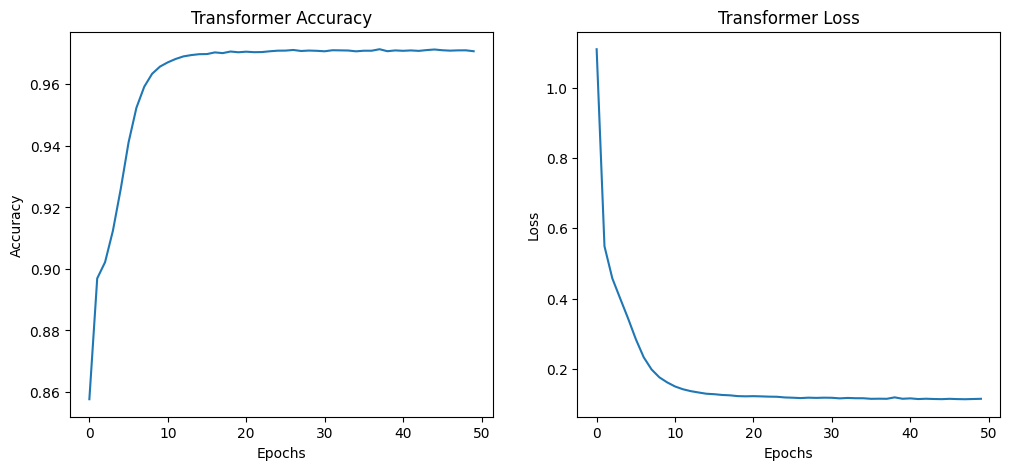

In [13]:
# Plot accuracy and loss graphs
plot_graphs(history_transformer, 'Transformer')

In [31]:
def generate_text(model, text, tokenizer, max_len, num_words=50):
    for _ in range(num_words):
        # Tokenize the input text
        token_text = tokenizer.texts_to_sequences([text])[0]
        

        # Ensure the length of input sequence is correct
        padded_token_text = pad_sequences([token_text], maxlen=max_len, padding='pre', truncating='pre')
        

        # Predict next word
        preds = model.predict(padded_token_text, verbose=0)
        

        # Take the last time step for predictions
        preds = preds[0, -1, :]  # Shape should be (vocab_size,)
        

        pred_idx = np.argmax(preds)        

        # Find the corresponding word for the predicted index
        predicted_word = tokenizer.index_word.get(pred_idx, "")
        
        # Append the predicted word to the text
        if predicted_word:
            text += " " + predicted_word            
        else:
            break  # If no word is predicted, break the loop

    return text

# Seed sentence for text generation
seed_text = "ML and Datascience will"

# Generate text using Transformer model
generated_text = generate_text(model_transformer, seed_text, tokenizer, max_len=56)  # Ensure max_len is set to 56

print("\nPrediction using Transformer Model:")
print(generated_text)



Prediction using Transformer Model:
ML and Datascience will we will we will we will we will we will we will we will we will we will we will we will we will we will we will we will we will be covering the course materials will be covering the course materials will be covering the following modules and
